In [1]:
conda activate TFgpu


Note: you may need to restart the kernel to use updated packages.


<div align="center">
  <img src="DisplayIMG/Cartoon.png" alt="Image Description" />
</div>

In [2]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as s
from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras_tuner import BayesianOptimization, HyperParameters
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
import seaborn as sns 

In [3]:
num_cores = os.cpu_count()  # Get number of CPU cores
num_cores_to_use = num_cores // 2  # Use half of the cores

num_cores

32

In [4]:
num_cores_to_use

16

# Load Data

In [5]:
current_directory = os.getcwd()

folder_name = "img"

folder_path = os.path.join(current_directory, folder_name)

csv_file_path = os.path.join(current_directory, "labels", "english-clean.csv")

df = pd.read_csv(csv_file_path)

# Create a dictionary where keys are filenames and values are labels
labels_dict = df.set_index('image')['label'].to_dict()



# Helper Function for Loading Images

In [6]:
def load_images_from_folder(folder, labels_dict):
    images = []
    labels = []
    for file_path in glob.glob(os.path.join(folder, "*.png")):
        img = Image.open(file_path)
        if img is not None:
            img = img.convert('L')  # Convert image to grayscale
            img = img.resize((64, 64))  # Resize the image to your desired size
            np_img = np.array(img)
            images.append(np_img)
            filename = os.path.basename(file_path)
            label = labels_dict[filename]  # Get the label from the filename
            labels.append(label)
    return images, labels


images, labels = load_images_from_folder(folder_path, labels_dict)

le = preprocessing.LabelEncoder()
numerical_labels = le.fit_transform(labels)  # Convert labels to integers

images = np.array(images)  # Convert list of arrays to a single array
mean = np.mean(images)
std = np.std(images)
images = (images - mean) / std  # Normalize pixel values
images = images.reshape(-1, 64, 64, 1)  # Reshape array for CNN

encoded_labels = to_categorical(numerical_labels)  # One-hot encode labels

# Split and Fit Data

<div align="center">
  <img src="DisplayIMG/Split & Fit.png" alt="Image Description" />
</div>

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42,
                                                    shuffle=True)

# Data augmentation for training data
datagen = ImageDataGenerator(
    rotation_range=35,  # Rotate images randomly by **% degrees
    width_shift_range=0.1,  # Shift images horizontally by **% of the width
    height_shift_range=0.1,  # Shift images vertically by **% of the height
    shear_range=0.0,  # Apply shear transformation with a shear intensity of **
    zoom_range=0.1,  # Apply zoom transformation with a zoom range of **
    horizontal_flip=False,  # Do not Flip images horizontally
    vertical_flip=False  # Do not flip images vertically
)

datagen.fit(X_train)

# Build Model

<div align="center">
  <img src="DisplayIMG/i_model.png" alt="Image Description" />
</div>

In [8]:
lr_decay = ReduceLROnPlateau(factor=0.1, patience=10)



model = Sequential()

# First block of convolutions
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)))  #Add Notes here******
model.add(BatchNormalization())                                                            #Add Notes here******
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))                           #Add Notes here******
model.add(BatchNormalization())                                                            
model.add(MaxPooling2D((2, 2)))                                                            #Add Notes here******
model.add(Dropout(0.1))                                                                    #Add Notes here******

# Second block of convolutions
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

# Fully connected layers
model.add(Flatten())                                                                       #Add Notes here******
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(len(le.classes_), activation='softmax'))                                   #Add Notes here******

# Compile model
model.compile(optimizer=Adam(learning_rate=0.01),                                          #Add Notes here******
              loss='categorical_crossentropy',                                             #Add Notes here******
              metrics=['accuracy'])                                                        #Add Notes here******


history = model.fit(datagen.flow(X_train, y_train),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=200,                                                            # Number of Runs in the Model
                    validation_data=(X_test, y_test),
                    callbacks=[lr_decay])                                                  #Add Notes here******

Epoch 1/200
85/85 [==============================] - 5s 52ms/step - loss: 4.6422 - accuracy: 0.0560 - val_loss: 54.0962 - val_accuracy: 0.0235 - lr: 0.0100
Epoch 2/200
85/85 [==============================] - 4s 51ms/step - loss: 3.6527 - accuracy: 0.1131 - val_loss: 42.2095 - val_accuracy: 0.0220 - lr: 0.0100
Epoch 3/200
85/85 [==============================] - 5s 55ms/step - loss: 2.6559 - accuracy: 0.2845 - val_loss: 9.6462 - val_accuracy: 0.0528 - lr: 0.0100
Epoch 4/200
85/85 [==============================] - 4s 50ms/step - loss: 2.2225 - accuracy: 0.3698 - val_loss: 3.7712 - val_accuracy: 0.2141 - lr: 0.0100
Epoch 5/200
85/85 [==============================] - 4s 46ms/step - loss: 1.9233 - accuracy: 0.4410 - val_loss: 7.8413 - val_accuracy: 0.1334 - lr: 0.0100
Epoch 6/200
85/85 [==============================] - 4s 48ms/step - loss: 1.6599 - accuracy: 0.5004 - val_loss: 5.3628 - val_accuracy: 0.1628 - lr: 0.0100
Epoch 7/200
85/85 [==============================] - 4s 48ms/step - 

85/85 [==============================] - 4s 46ms/step - loss: 0.6026 - accuracy: 0.8082 - val_loss: 0.6674 - val_accuracy: 0.7815 - lr: 1.0000e-10
Epoch 104/200
85/85 [==============================] - 4s 47ms/step - loss: 0.6004 - accuracy: 0.8097 - val_loss: 0.6694 - val_accuracy: 0.7845 - lr: 1.0000e-10
Epoch 105/200
85/85 [==============================] - 4s 45ms/step - loss: 0.6106 - accuracy: 0.8038 - val_loss: 0.6625 - val_accuracy: 0.7859 - lr: 1.0000e-10
Epoch 106/200
85/85 [==============================] - 4s 48ms/step - loss: 0.6147 - accuracy: 0.8131 - val_loss: 0.6649 - val_accuracy: 0.7845 - lr: 1.0000e-10
Epoch 107/200
85/85 [==============================] - 4s 48ms/step - loss: 0.6132 - accuracy: 0.8157 - val_loss: 0.6646 - val_accuracy: 0.7845 - lr: 1.0000e-10
Epoch 108/200
85/85 [==============================] - 4s 46ms/step - loss: 0.5990 - accuracy: 0.8142 - val_loss: 0.6716 - val_accuracy: 0.7801 - lr: 1.0000e-10
Epoch 109/200
85/85 [===========================

Epoch 154/200
85/85 [==============================] - 4s 48ms/step - loss: 0.6158 - accuracy: 0.8068 - val_loss: 0.6671 - val_accuracy: 0.7845 - lr: 1.0000e-15
Epoch 155/200
85/85 [==============================] - 4s 52ms/step - loss: 0.6150 - accuracy: 0.8053 - val_loss: 0.6711 - val_accuracy: 0.7830 - lr: 1.0000e-15
Epoch 156/200
85/85 [==============================] - 4s 49ms/step - loss: 0.6265 - accuracy: 0.7949 - val_loss: 0.6630 - val_accuracy: 0.7830 - lr: 1.0000e-15
Epoch 157/200
85/85 [==============================] - 4s 47ms/step - loss: 0.6219 - accuracy: 0.7975 - val_loss: 0.6603 - val_accuracy: 0.7830 - lr: 1.0000e-15
Epoch 158/200
85/85 [==============================] - 4s 47ms/step - loss: 0.6207 - accuracy: 0.8042 - val_loss: 0.6651 - val_accuracy: 0.7815 - lr: 1.0000e-15
Epoch 159/200
85/85 [==============================] - 4s 51ms/step - loss: 0.6097 - accuracy: 0.7990 - val_loss: 0.6719 - val_accuracy: 0.7815 - lr: 1.0000e-16
Epoch 160/200
85/85 [=============

In [9]:
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

86/86 [==============================] - 1s 11ms/step - loss: 0.4071 - accuracy: 0.8739
Train Loss: 0.4071109890937805
Train Accuracy: 0.873900294303894


# Model Architecture Visualization:

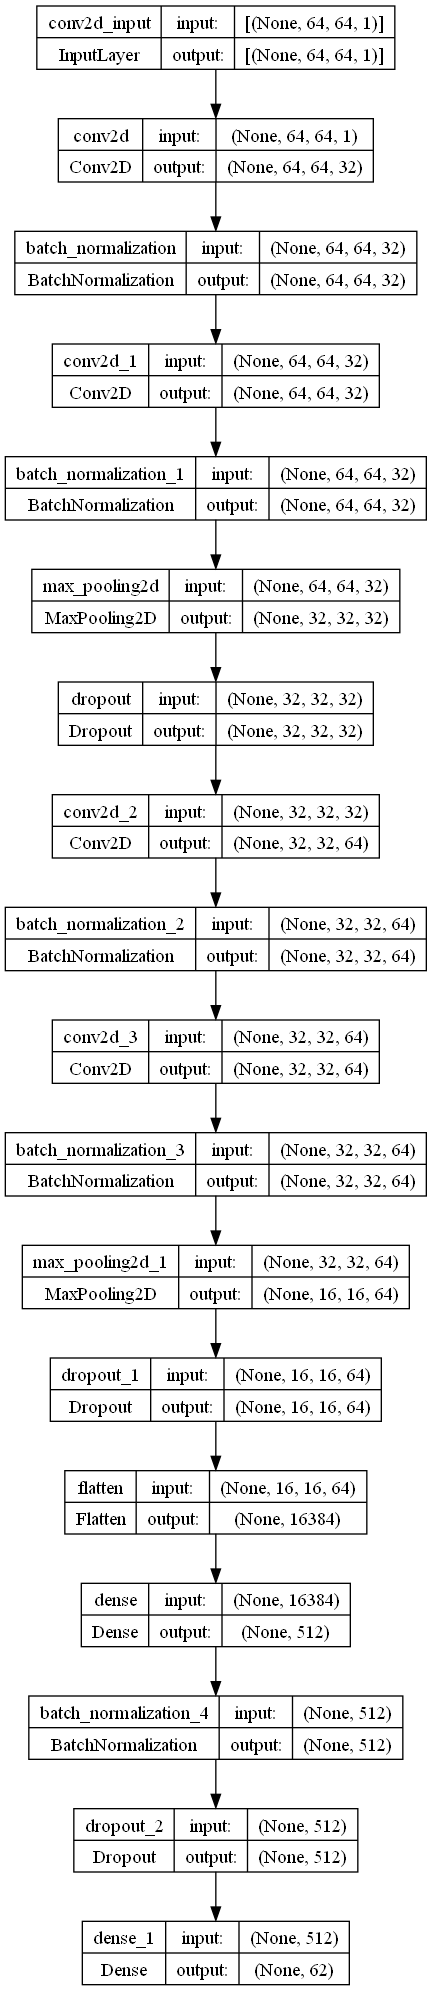

In [10]:
from keras.utils import plot_model

# Generate the plot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                        

In [12]:
for layer in model.layers:
    print(layer.name)

conv2d
batch_normalization
conv2d_1
batch_normalization_1
max_pooling2d
dropout
conv2d_2
batch_normalization_2
conv2d_3
batch_normalization_3
max_pooling2d_1
dropout_1
flatten
dense
batch_normalization_4
dropout_2
dense_1


# Visualize

<div align="center">
  <img src="DisplayIMG/Data_Lung.png" alt="Image Description" />
</div>

In [13]:

# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

plt.tight_layout()
plt.show()
[7]
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print a classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_, zero_division=1))

<Figure size 640x480 with 0 Axes>

22/22 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.83      0.36      0.50        14
           1       0.40      0.36      0.38        11
           2       1.00      0.90      0.95        10
           3       1.00      0.90      0.95        20
           4       0.93      1.00      0.97        14
           5       0.86      0.75      0.80        16
           6       0.67      0.89      0.76         9
           7       1.00      0.87      0.93        15
           8       0.77      0.83      0.80        12
           9       0.83      0.45      0.59        11
           A       1.00      1.00      1.00        16
           B       0.80      0.89      0.84         9
           C       0.86      0.67      0.75         9
           D       0.83      1.00      0.91        10
           E       0.94      1.00      0.97        15
           F       1.00      0.93      0.96        14
           G       0.89    

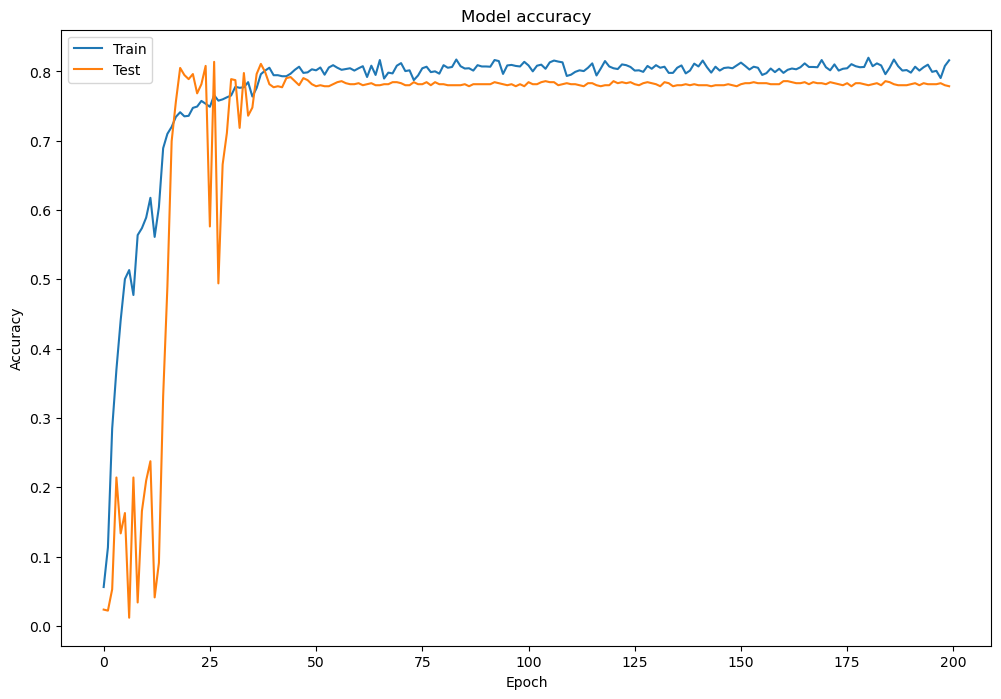

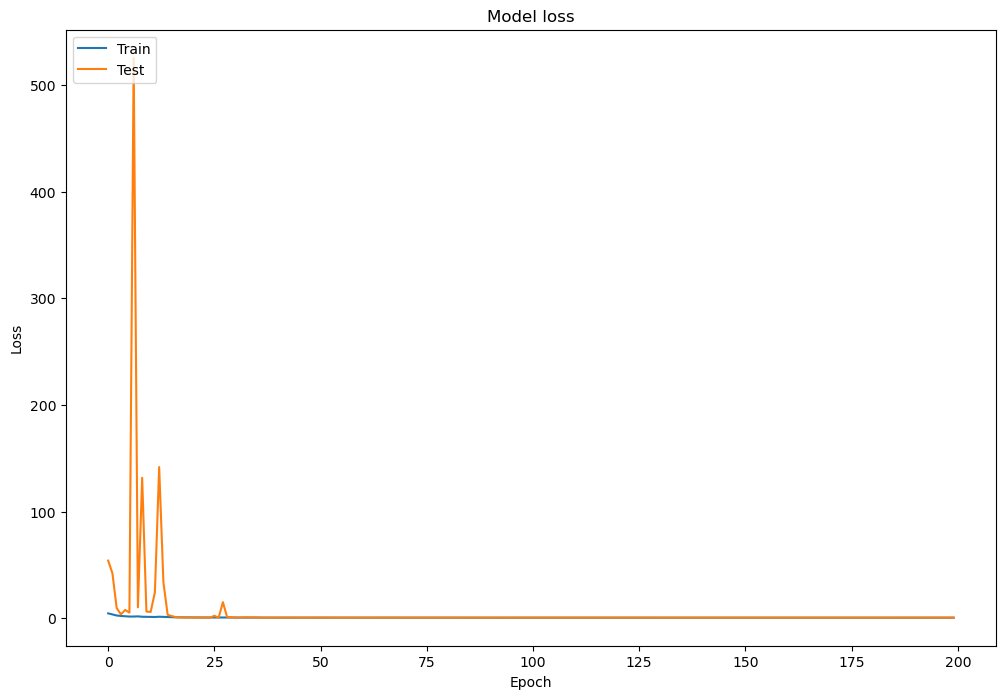

Evaluate on test data
6/6 [==============================] - 0s 34ms/step - loss: 0.6738 - accuracy: 0.7786
test loss, test accuracy: [0.6738434433937073, 0.7785923480987549]


In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=[12,8])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=[12,8])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test accuracy:", results)

22/22 [==============================] - 0s 10ms/step


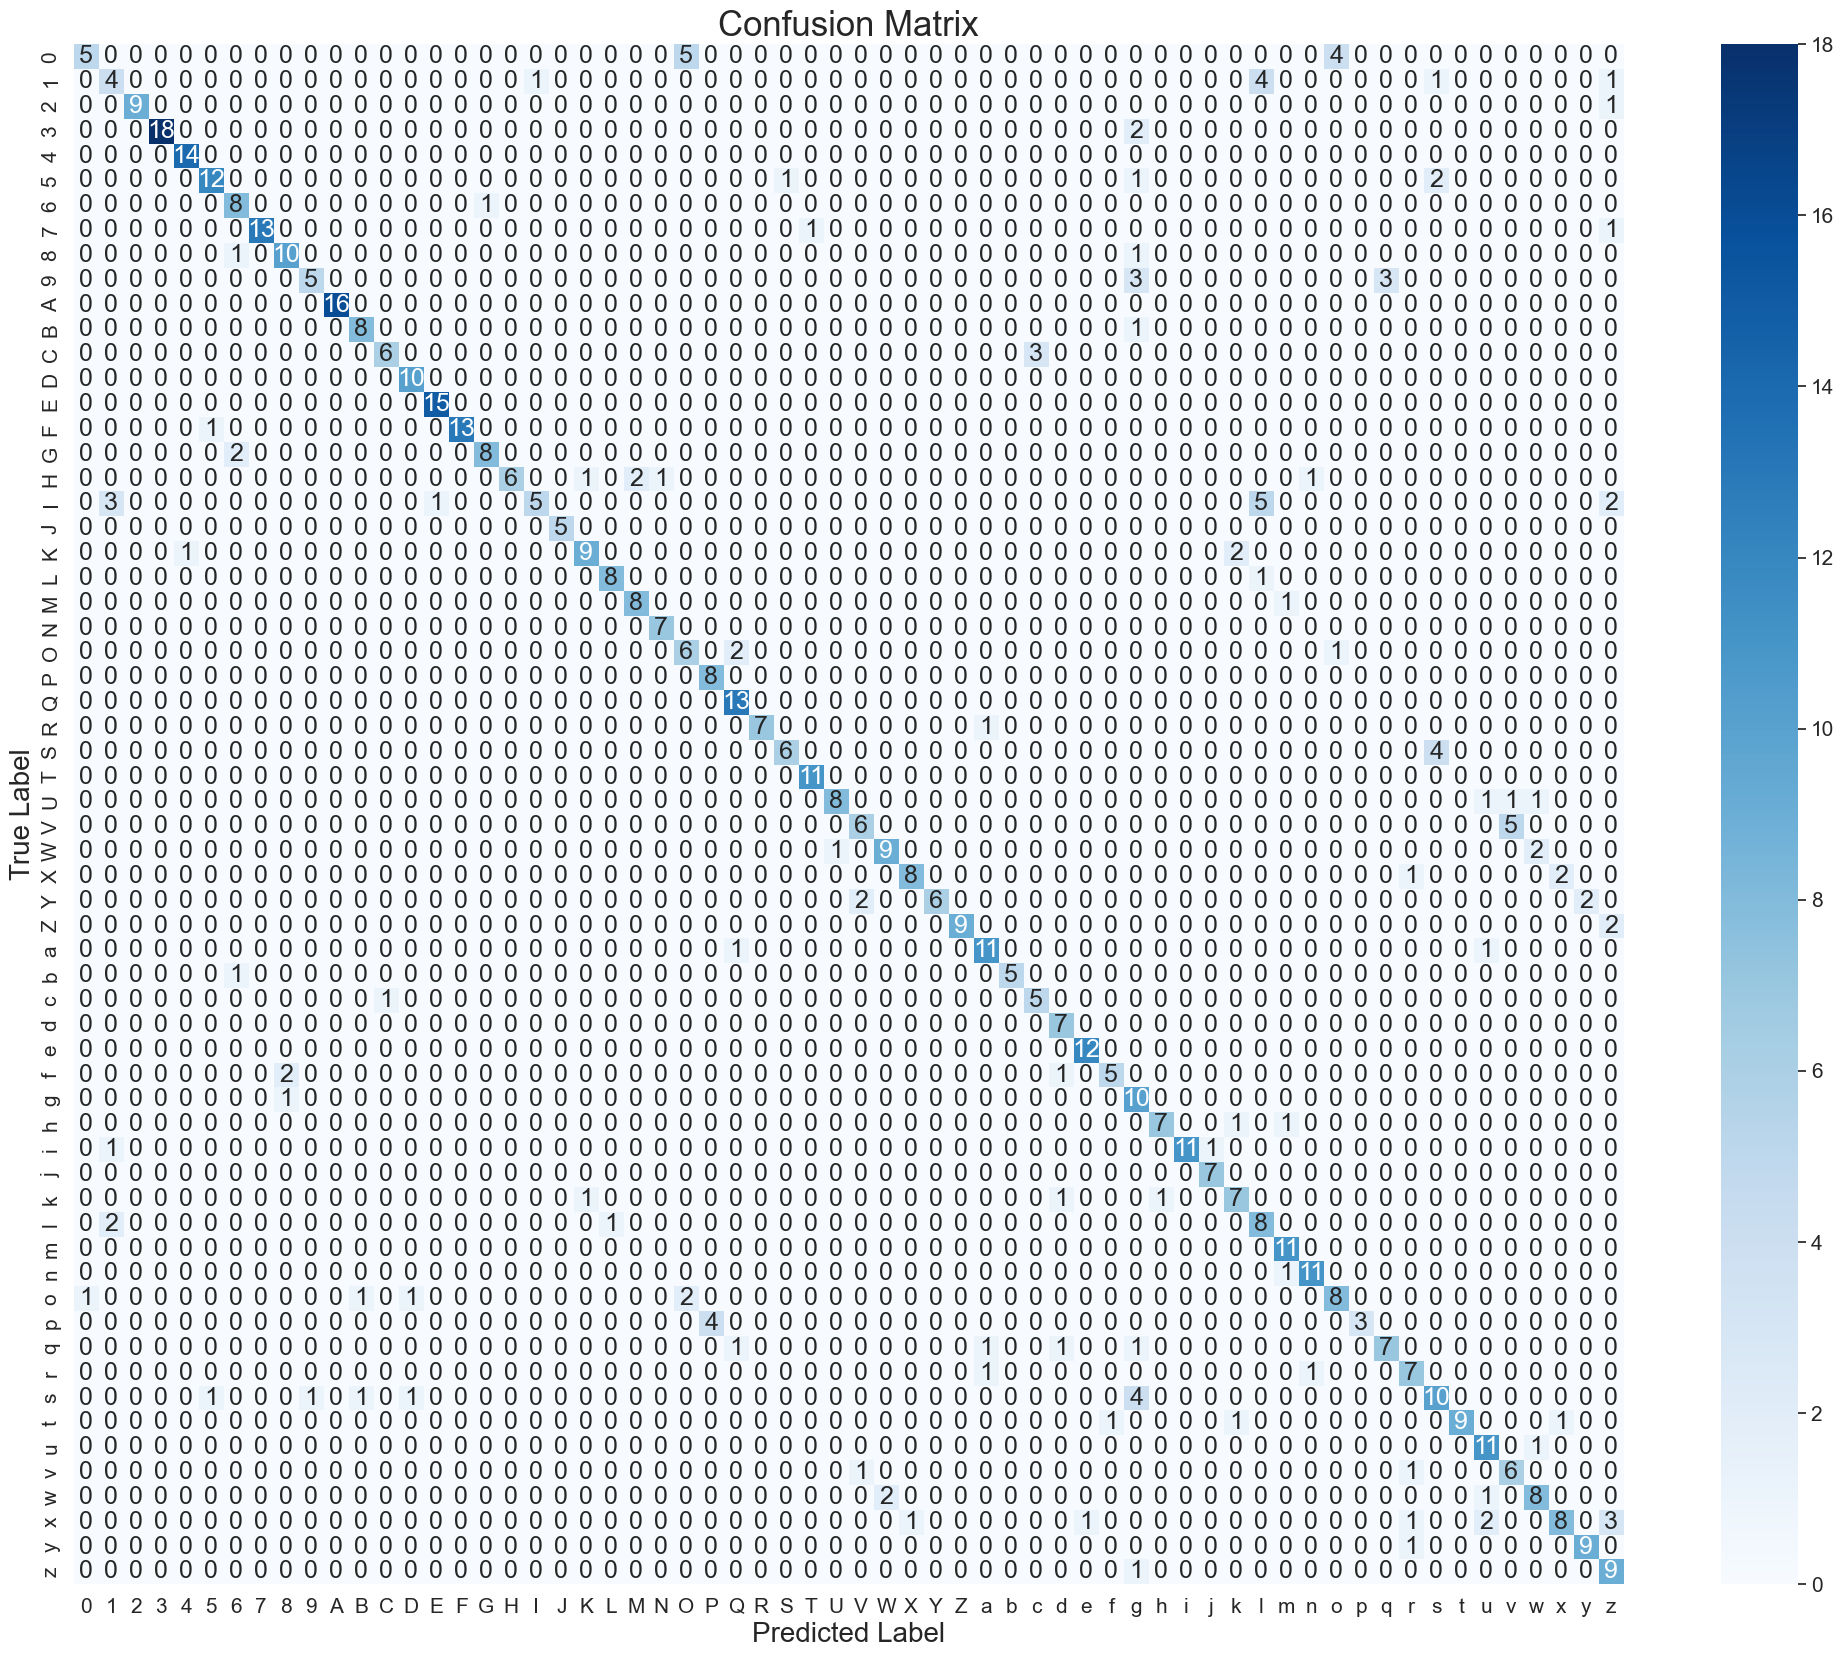

In [15]:


# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert probabilities to labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Also convert the one-hot encoded labels back to label encoding
y_true_labels = np.argmax(y_test, axis=1)

# Convert numerical labels back to original labels
y_pred_labels = le.inverse_transform(y_pred_labels)
y_true_labels = le.inverse_transform(y_true_labels)

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

# Create a list of unique labels
labels = list(le.classes_)

# Set the font scale (this will affect heatmap annotation size)
sns.set(font_scale=1.5)

# Adjust size of labels, title using rcParams
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

# Visualize confusion matrix using seaborn's heatmap
plt.figure(figsize=(25, 20))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix', fontsize=25)
plt.show()


In [16]:
# #Save Model For Furture Use
# model.save('EpochTenThousand')

In [17]:
# import pickle

# # Assume you have a history object from model.fit
# # history = model.fit(....)

# # Save it under some name
# with open('trainHistoryDict', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)


In [18]:
# with open('trainHistoryDict', 'rb') as file_pi:
#     loaded_history = pickle.load(file_pi)

In [19]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, zero_division=1))

# Print confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(confusion_mtx)

22/22 [==============================] - 0s 11ms/step - loss: 0.6738 - accuracy: 0.7786
Test Loss: 0.6738433837890625
Test Accuracy: 0.7785923480987549
22/22 [==============================] - 0s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.36      0.50        14
           1       0.40      0.36      0.38        11
           2       1.00      0.90      0.95        10
           3       1.00      0.90      0.95        20
           4       0.93      1.00      0.97        14
           5       0.86      0.75      0.80        16
           6       0.67      0.89      0.76         9
           7       1.00      0.87      0.93        15
           8       0.77      0.83      0.80        12
           9       0.83      0.45      0.59        11
          10       1.00      1.00      1.00        16
          11       0.80      0.89      0.84         9
          12       0.86      0.67      0.75         9
          13  

# Class Activation Maps (CAM):

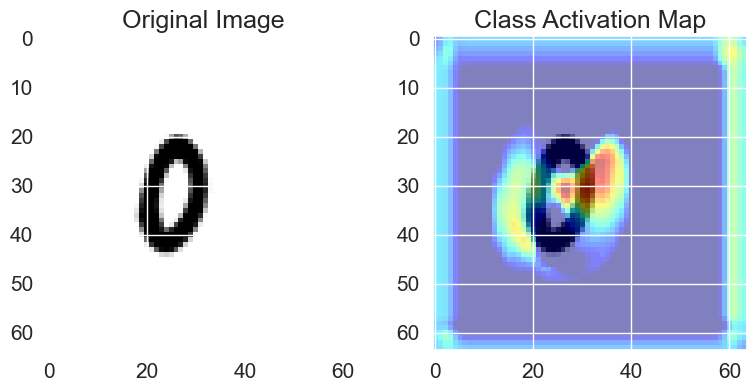

In [20]:
import numpy as np
import tensorflow.keras.backend as K

def visualize_cam(model, img):
    # Extract the last convolutional layer
    last_conv_layer = model.get_layer('conv2d_3')
    
    # Define a new model that outputs the last conv layer and the model's predicted class probabilities
    cam_model = tf.keras.Model(model.input, (last_conv_layer.output, model.output))
    
    # Calculate the gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = cam_model(img)
        predicted_class = tf.argmax(predictions[0])
        gradient = tape.gradient(predictions[:, predicted_class], conv_outputs)
    
    # Compute the weights using global average pooling on the gradients
    weights = tf.reduce_mean(gradient[0], axis=(0, 1))
    
    # Get the feature map values and resize them to match the input image size
    feature_map = conv_outputs[0]
    cam = np.dot(feature_map, weights)
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    
    return cam


# Choose an image from the test set
test_image = X_test[4]

# Reshape the image to match the input shape of the model
test_image = np.reshape(test_image, (1, 64, 64, 1))

# Generate the CAM for the chosen image
cam = visualize_cam(model, test_image)

# Plot the original image and the CAM
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title('Class Activation Map')

plt.tight_layout()
plt.show()


In [21]:
def visualize_cam(model, img):
    # Extract the last convolutional layer
    last_conv_layer = model.get_layer('conv2d_3')
    
    # Define a new model that outputs the last conv layer and the model's predicted class probabilities
    cam_model = tf.keras.Model(model.input, (last_conv_layer.output, model.output))
    
    # Calculate the gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = cam_model(img)
        predicted_class = tf.argmax(predictions[0])
        gradient = tape.gradient(predictions[:, predicted_class], conv_outputs)
    
    # Compute the weights using global average pooling on the gradients
    weights = tf.reduce_mean(gradient[0], axis=(0, 1))
    
    # Get the feature map values and resize them to match the input image size
    feature_map = conv_outputs[0]
    cam = np.dot(feature_map, weights)
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    
    return cam


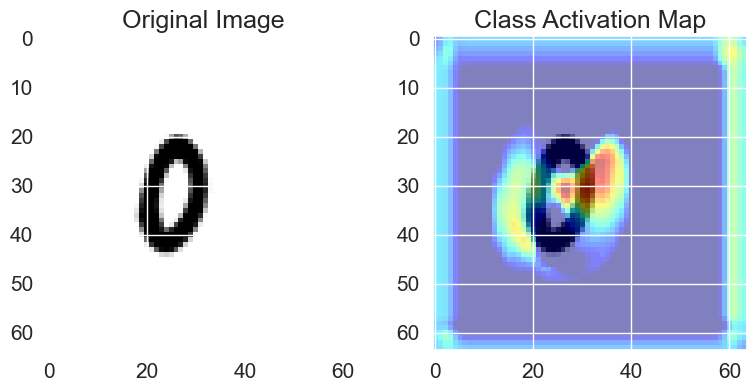

In [22]:


cam = visualize_cam(model, test_image)

# Plot the original image and the CAM
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title('Class Activation Map')

plt.tight_layout()
plt.show()


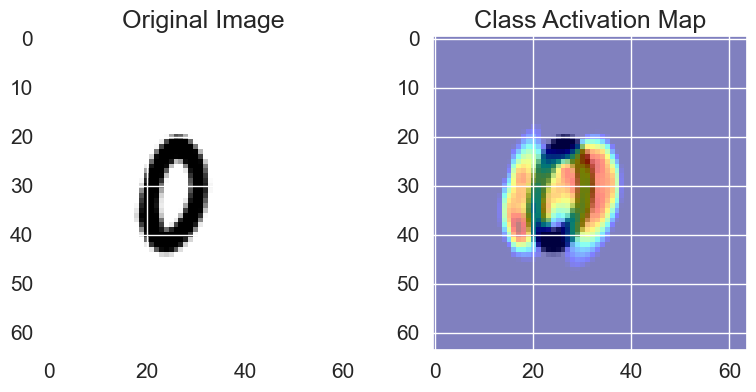

In [23]:
def visualize_cam(model, img):
    # Extract the last convolutional layer
    last_conv_layer = model.get_layer('conv2d_2')
    
    # Define a new model that outputs the last conv layer and the model's predicted class probabilities
    cam_model = tf.keras.Model(model.input, (last_conv_layer.output, model.output))
    
    # Reshape the input image to match the expected input shape of the model
    img = np.reshape(img, (1, 64, 64, 1))
    
    # Calculate the gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = cam_model(img)
        predicted_class = tf.argmax(predictions[0])
        gradient = tape.gradient(predictions[:, predicted_class], conv_outputs)
    
    # Compute the weights using global average pooling on the gradients
    weights = tf.reduce_mean(gradient[0], axis=(0, 1))
    
    # Get the feature map values and resize them to match the input image size
    feature_map = conv_outputs[0]
    cam = np.dot(feature_map, weights)
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    
    return cam

cam = visualize_cam(model, test_image)

# Plot the original image and the CAM
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title('Class Activation Map')

plt.tight_layout()
plt.show()


# Class Activation Maps (CAM) of First Layer

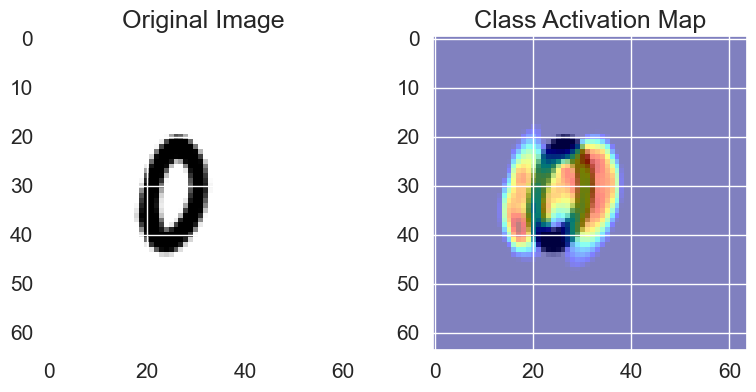

In [24]:
def visualize_cam(model, img):
    # Extract the last convolutional layer
    last_conv_layer = model.get_layer('conv2d_2')
    
    # Define a new model that outputs the last conv layer and the model's predicted class probabilities
    cam_model = tf.keras.Model(model.input, (last_conv_layer.output, model.output))
    
    # Reshape the input image to match the expected input shape of the model
    img = np.reshape(img, (-1, 64, 64, 1))
    
    # Calculate the gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = cam_model(img)
        predicted_class = tf.argmax(predictions[0])
        gradient = tape.gradient(predictions[:, predicted_class], conv_outputs)
    
    # Compute the weights using global average pooling on the gradients
    weights = tf.reduce_mean(gradient[0], axis=(0, 1))
    
    # Get the feature map values and resize them to match the input image size
    feature_map = conv_outputs[0]
    cam = np.dot(feature_map, weights)
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    
    return cam



# Reshape the image to match the expected input shape of the model
test_image = np.reshape(test_image, (64, 64))
test_image = np.expand_dims(test_image, axis=-1)
test_image = np.expand_dims(test_image, axis=0)

cam = visualize_cam(model, test_image)

# Plot the original image and the CAM
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title('Class Activation Map')

plt.tight_layout()
plt.show()


# Class Activation Maps (CAM) of 2nd Layer:

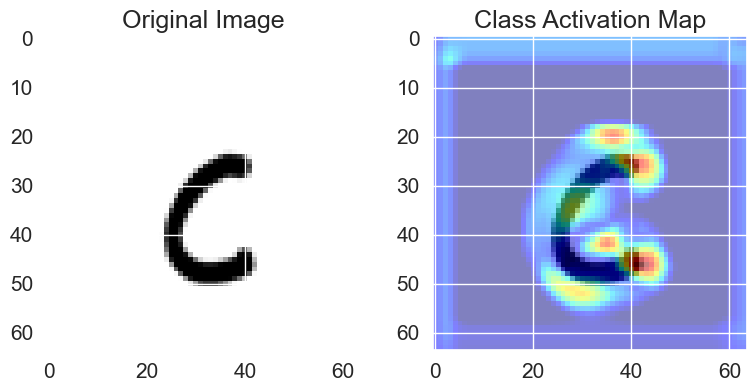

In [25]:

def visualize_cam(model, img):
    # Extract the last convolutional layer
    last_conv_layer = model.get_layer('conv2d_3')
    
    # Define a new model that outputs the last conv layer and the model's predicted class probabilities
    cam_model = tf.keras.Model(model.input, (last_conv_layer.output, model.output))
    
    # Calculate the gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = cam_model(img)
        predicted_class = tf.argmax(predictions[0])
        gradient = tape.gradient(predictions[:, predicted_class], conv_outputs)
    
    # Compute the weights using global average pooling on the gradients
    weights = tf.reduce_mean(gradient[0], axis=(0, 1))
    
    # Get the feature map values and resize them to match the input image size
    feature_map = conv_outputs[0]
    cam = np.dot(feature_map, weights)
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    
    return cam


# Choose an image from the test set
test_image = X_test[3]

# Reshape the image to match the input shape of the model
test_image = np.reshape(test_image, (1, 64, 64, 1))

# Generate the CAM for the chosen image
cam = visualize_cam(model, test_image)

# Plot the original image and the CAM
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title('Class Activation Map')

plt.tight_layout()
plt.show()


# Grad-CAM:

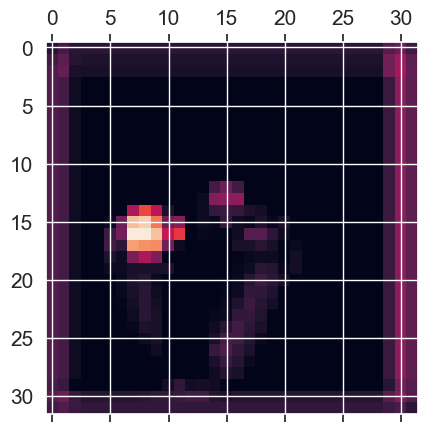

In [26]:
from tensorflow.keras.models import Model

# Select a sample image from your test set
sample_image = X_test[0]

# Create a model that maps the input image to the activations of the last conv layer as well as the output predictions
grad_model = Model([model.inputs], [model.get_layer('conv2d_3').output, model.output])

# Get the gradient of the top predicted class for our input image with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(np.expand_dims(sample_image, axis=0))
    pred_index = np.argmax(preds[0])
    class_channel = preds[:, pred_index]

# This is the gradient of the output neuron (top predicted or chosen)
# with regard to the output feature map of the last conv layer
grads = tape.gradient(class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array by "how important this channel is"
# with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., np.newaxis]
heatmap = np.squeeze(heatmap)

# Normalize the heatmap between 0 & 1 for visualization
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

# Show the heatmap
plt.matshow(heatmap)
plt.show()


# Feature Maps:

1/1 [==============================] - 0s 55ms/step


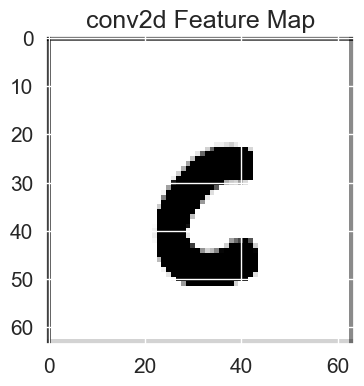

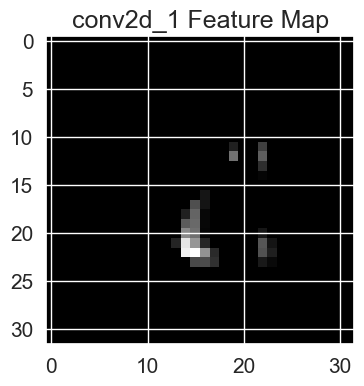

In [27]:
def visualize_feature_maps(model, img):
    # Extract the intermediate feature maps
    layer_outputs = [layer.output for layer in model.layers if 'conv2d' in layer.name]
    activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
    feature_maps = activation_model.predict(img)
    
    # Plot the feature maps
    for layer, feature_map in zip(model.layers, feature_maps):
        if 'conv2d' in layer.name:
            plt.figure(figsize=(8, 4))
            plt.imshow(feature_map[0, :, :, 0], cmap='gray')
            plt.title(layer.name + ' Feature Map')
            plt.show()

# Visualize the feature maps for the chosen image
visualize_feature_maps(model, test_image)


# Filter Visualization:

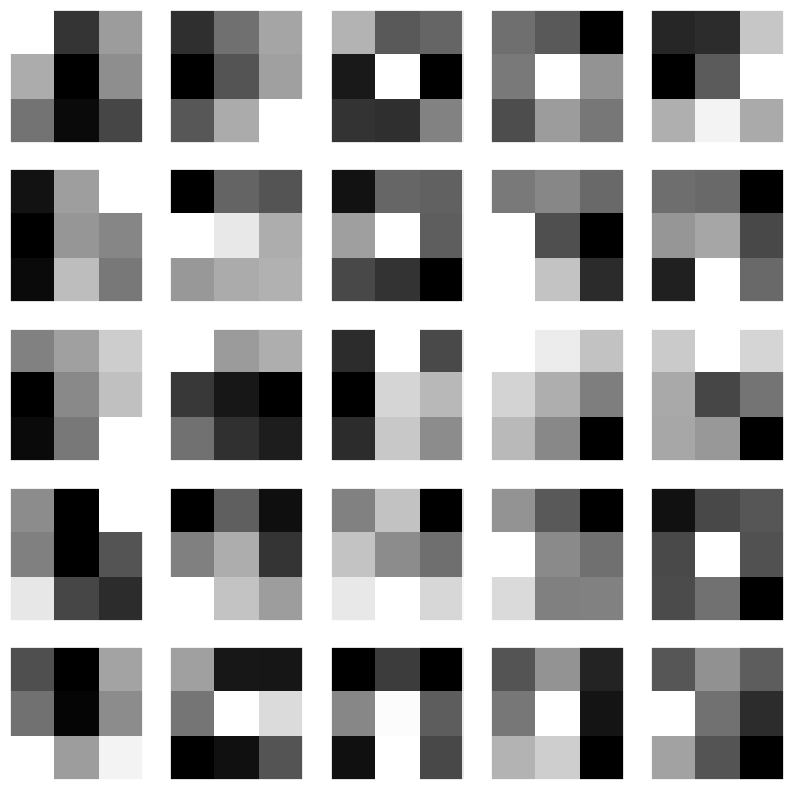

In [28]:
# Get the weights of the first convolution layer
weights1 = model.layers[0].get_weights()[0]

# Normalize the weights to be between 0 and 1
weights1 = (weights1 - weights1.min())/(weights1.max()-weights1.min())

# Plot the weights as images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(weights1[:,:,:,i], cmap='gray')
plt.show()


# Activation Histograms:

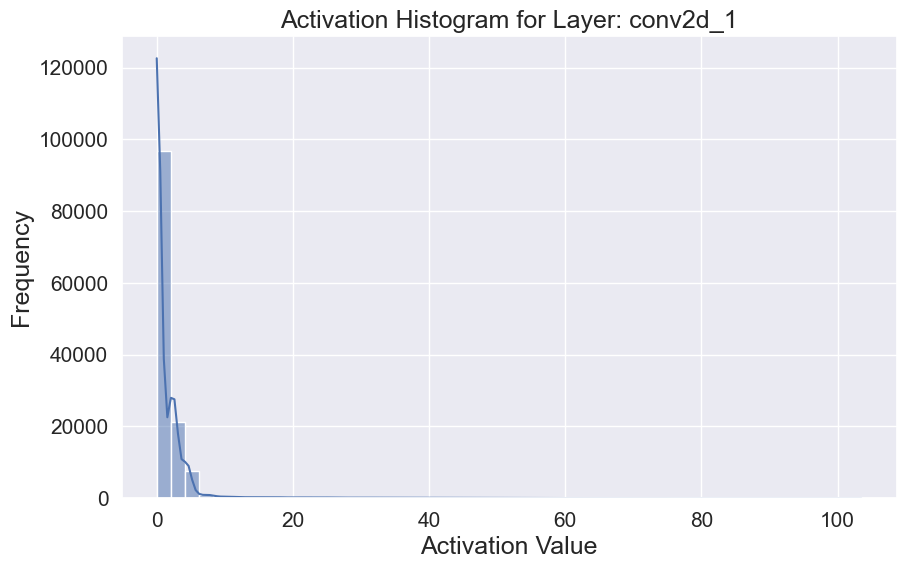

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Specify the layer you want to visualize
layer_name = 'conv2d_1'  # Change this to the layer name you're interested in
filter_index = 0  # Can be any integer from 0 to 511, as there are 512 filters in that layer

# Grab a reference to the input of the model and the specified layer
input_img = model.input
layer_output = layer_dict[layer_name].output

# Build a function that returns the activation values given the input picture
activation_func = K.function([input_img], [layer_output])

# Use the above function to compute the activations
activations = activation_func([X_test[0].reshape(1, 64, 64, 1)])

# Get histogram data
activation_values = activations[0].flatten()

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(activation_values, bins=50, kde=True)
plt.title(f'Activation Histogram for Layer: {layer_name}')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.show()


# Learning Curves:

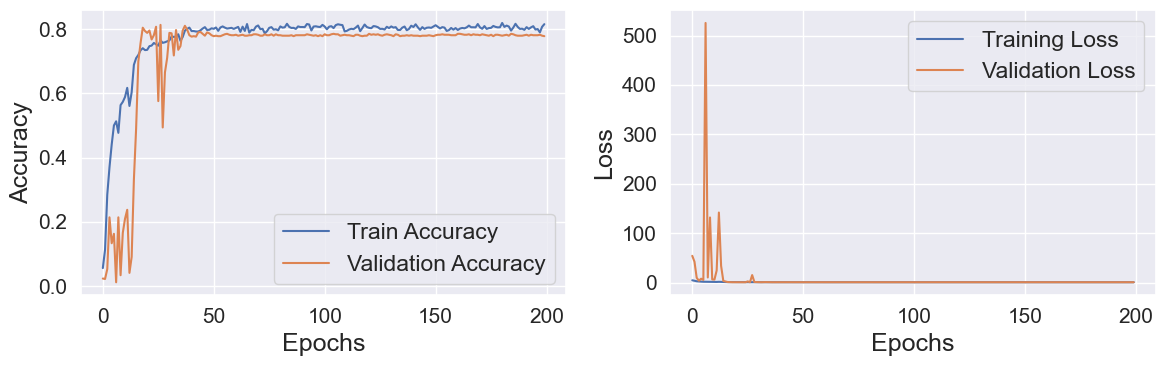

In [30]:
# Plotting the accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Details on Image Files

In [31]:
# Specify the folder path containing the images
folder_path = "Img"

# Get a list of image file names in the folder
image_files = os.listdir(folder_path)

# Iterate over the image files
for file_name in image_files:
    # Construct the full file path
    file_path = os.path.join(folder_path, file_name)

    # Open the image file
    image = Image.open(file_path)

    # Get the pixel size of the image
    width, height = image.size

    # Print the pixel size
    print(f"Image: {file_name}, Width: {width}px, Height: {height}px")

Image: img001-001.png, Width: 1200px, Height: 900px
Image: img001-002.png, Width: 1200px, Height: 900px
Image: img001-003.png, Width: 1200px, Height: 900px
Image: img001-004.png, Width: 1200px, Height: 900px
Image: img001-005.png, Width: 1200px, Height: 900px
Image: img001-006.png, Width: 1200px, Height: 900px
Image: img001-007.png, Width: 1200px, Height: 900px
Image: img001-008.png, Width: 1200px, Height: 900px
Image: img001-009.png, Width: 1200px, Height: 900px
Image: img001-010.png, Width: 1200px, Height: 900px
Image: img001-011.png, Width: 1200px, Height: 900px
Image: img001-012.png, Width: 1200px, Height: 900px
Image: img001-013.png, Width: 1200px, Height: 900px
Image: img001-014.png, Width: 1200px, Height: 900px
Image: img001-015.png, Width: 1200px, Height: 900px
Image: img001-016.png, Width: 1200px, Height: 900px
Image: img001-017.png, Width: 1200px, Height: 900px
Image: img001-018.png, Width: 1200px, Height: 900px
Image: img001-019.png, Width: 1200px, Height: 900px
Image: img00

Image: img048-022.png, Width: 1200px, Height: 900px
Image: img048-023.png, Width: 1200px, Height: 900px
Image: img048-024.png, Width: 1200px, Height: 900px
Image: img048-025.png, Width: 1200px, Height: 900px
Image: img048-026.png, Width: 1200px, Height: 900px
Image: img048-027.png, Width: 1200px, Height: 900px
Image: img048-028.png, Width: 1200px, Height: 900px
Image: img048-029.png, Width: 1200px, Height: 900px
Image: img048-030.png, Width: 1200px, Height: 900px
Image: img048-031.png, Width: 1200px, Height: 900px
Image: img048-032.png, Width: 1200px, Height: 900px
Image: img048-033.png, Width: 1200px, Height: 900px
Image: img048-034.png, Width: 1200px, Height: 900px
Image: img048-035.png, Width: 1200px, Height: 900px
Image: img048-036.png, Width: 1200px, Height: 900px
Image: img048-037.png, Width: 1200px, Height: 900px
Image: img048-038.png, Width: 1200px, Height: 900px
Image: img048-039.png, Width: 1200px, Height: 900px
Image: img048-040.png, Width: 1200px, Height: 900px
Image: img04

In [32]:
#128 by (check proper size)


#Build out readme and PPT!!!!!!!!!!!!!



#Learn a deployment!!!!

